# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
import classes.file_loader as file_loader
import classes.arma as arma

# Data Preprocessing

## Loading Files

In [3]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [4]:
classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  classic_raw_df.fillna(method = "ffill", inplace=True)
c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precarity_raw_df.fillna(method = "ffill", inplace=True)


In [5]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [6]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [7]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.164452
2,2023-04-26,7.260847
3,2023-04-27,7.301743
4,2023-04-28,7.293128
...,...,...
446,2025-01-07,7.926451
447,2025-01-08,8.010066
448,2025-01-09,7.973595
449,2025-01-10,7.993539


In [8]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.282124
2,2023-04-26,7.357566
3,2023-04-27,7.304711
4,2023-04-28,7.377571
...,...,...
446,2025-01-07,10.071784
447,2025-01-08,10.184001
448,2025-01-09,10.102117
449,2025-01-10,9.947048


## Plotting the augmented dataframes 

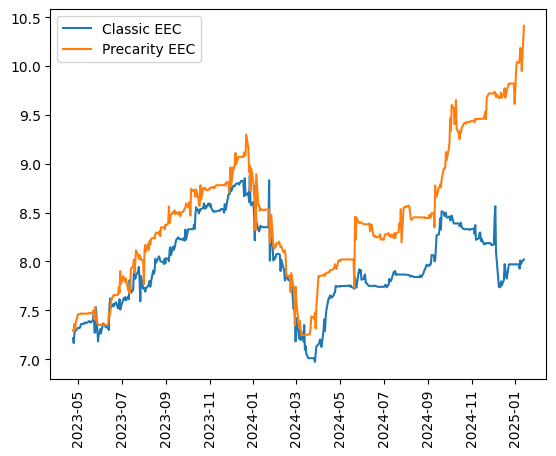

In [9]:
plt.figure()

plt.plot(augmented_classic_df["Date"], augmented_classic_df["SPOT"], label = "Classic EEC")
plt.plot(augmented_precarity_df["Date"], augmented_precarity_df["SPOT"], label = "Precarity EEC")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

# Data forecasting

## Tests

### Stationnarity

From the Graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [10]:
classic_df = augmented_classic_df.copy()
classic_df["Delta"] = classic_df["SPOT"] - classic_df["SPOT"].shift(1)
classic_df.dropna(inplace = True)
classic_df

,Date,SPOT,Delta
1,2023-04-25,7.164452,-0.048264
2,2023-04-26,7.260847,0.096395
3,2023-04-27,7.301743,0.040896
4,2023-04-28,7.293128,-0.008615
5,2023-05-01,7.321166,0.028037
...,...,...,...
446,2025-01-07,7.926451,-0.043549
447,2025-01-08,8.010066,0.083615
448,2025-01-09,7.973595,-0.036470
449,2025-01-10,7.993539,0.019943


In [11]:
result = adfuller(classic_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 3.5751703062267035e-25
Result: reject unit root -> series is stationary (at 5% level).


In [12]:
precarity_df = augmented_precarity_df.copy()
precarity_df["Delta"] = precarity_df["SPOT"] - precarity_df["SPOT"].shift(1)
precarity_df.dropna(inplace = True)
precarity_df

,Date,SPOT,Delta
1,2023-04-25,7.282124,-0.014659
2,2023-04-26,7.357566,0.075442
3,2023-04-27,7.304711,-0.052856
4,2023-04-28,7.377571,0.072860
5,2023-05-01,7.460184,0.082613
...,...,...,...
446,2025-01-07,10.071784,0.041784
447,2025-01-08,10.184001,0.112217
448,2025-01-09,10.102117,-0.081884
449,2025-01-10,9.947048,-0.155069


In [13]:
result = adfuller(precarity_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 1.5050039204618908e-13
Result: reject unit root -> series is stationary (at 5% level).


## ARIMA

We create an ARMA model (in reality ARIMA as the series wwas already differentiated), using a class built on our own.

In [14]:
# Initiate the ARMA class
ARMA = arma.ARMA(classic_df["Delta"])

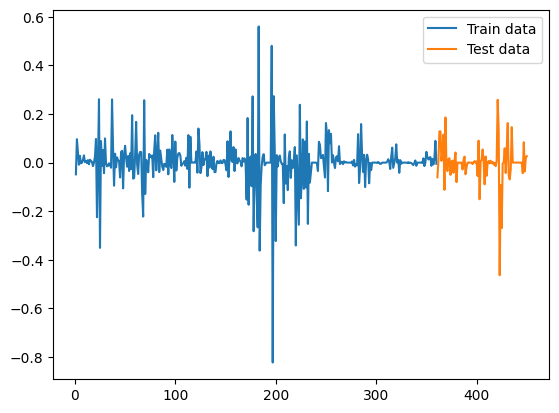

In [15]:
ARMA.train_test_split()

plt.figure()
plt.plot(ARMA.train_dependent, label="Train data")
plt.plot(ARMA.test_dependent, label="Test data")
plt.legend()
plt.show()

In [16]:
# Selecting the last relevant lags
ma_max_order = ARMA.get_ma_max_order()
ar_max_order = ARMA.get_ar_max_order()
print(f"Max MA order: {ma_max_order}, Max AR order: {ar_max_order}")

[ 1.         -0.47019337  0.00279665  0.21532594 -0.08429146  0.01215081
  0.04783946 -0.01963044  0.0588976  -0.02345419  0.00463895]
[[ 1.          1.        ]
 [-0.57349254 -0.36689419]
 [-0.12125544  0.12684875]
 [ 0.09127317  0.33937871]
 [-0.21227033  0.04368741]
 [-0.11641911  0.14072072]
 [-0.08074271  0.17642163]
 [-0.14840239  0.10914151]
 [-0.06990628  0.18770148]
 [-0.15254514  0.10563675]
 [-0.12449746  0.13377536]]
[ 1.         -0.4715031  -0.28225174  0.11981211  0.13576665  0.09403746
  0.05283339  0.01474834  0.07553302  0.03657794  0.00757344]
[[ 1.          1.        ]
 [-0.57480227 -0.36820392]
 [-0.38555091 -0.17895257]
 [ 0.01651294  0.22311129]
 [ 0.03246748  0.23906582]
 [-0.00926172  0.19733663]
 [-0.05046578  0.15613257]
 [-0.08855084  0.11804751]
 [-0.02776615  0.1788322 ]
 [-0.06672124  0.13987711]
 [-0.09572574  0.11087261]]
Max MA order: 0, Max AR order: 0


## LSTM

## GRU